In [ ]:
%run functions.py
%run plot_functions.py

import numpy as np
import pandas as pd
from scipy.io import loadmat
from copy import deepcopy
import matplotlib.pyplot as plt
from itertools import product

from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

## Load settings

In [ ]:
pd.set_option('display.max_colwidth',-1)

k=10
seed = 42
limit_features = 9
np.random.seed(seed)
scoring='accuracy'

## Load dataset

In [ ]:
filename = "datasets/ECGITtrain.mat"

mat = loadmat(filename)
input_train = mat['inputECGITtrain'].T

target_train = mat['outputECGITtrain'].reshape(len(input_train))
input_test = mat['inputECGITtest']

## Data info

In [ ]:
# The shape should look like (401,133) where 401 is the number of features and 133 is each row
print("Length of",len(input_train))
print("X.shape:", input_train.shape, "y.shape:", target_train.shape)    
print("Contains Nan:",np.isnan(input_train).any(), np.isnan(target_train).any())
print("Contains +inf:",np.isinf(input_train).any(),np.isinf(target_train).any())
print("Contains -inf:",np.isneginf(input_train).any(),np.isneginf(target_train).any())
pd.DataFrame(input_train).describe()

## Preprocess

In [105]:
input_train_copy = deepcopy(input_train)

# Normalizing data
scaler = StandardScaler()
scaler.fit(input_train,y=target_train)

input_train_copy_normalized = deepcopy(input_train_copy)

input_train = scaler.transform(input_train)
input_test = scaler.transform(input_test)

# Feature selection
pca = PCA(n_components = .95, svd_solver = 'full')
pca.fit(input_train,y=input_train)

input_train = pca.transform(input_train)
input_test = pca.transform(input_test)

print("original shape:   ", input_train_copy.shape)
print("transformed shape:", input_train.shape)
print("Explained variance:",pca.explained_variance_ratio_)


original shape:    (5000, 21)
transformed shape: (5000, 19)
Explained variance: [0.11644462 0.07693855 0.06624585 0.05484826 0.05400037 0.05290859
 0.04951334 0.04840626 0.04679861 0.04582658 0.04538423 0.04431255
 0.04244733 0.04194532 0.04107869 0.04019269 0.03850317 0.03597675
 0.03242482]


## Plot info of data
Plotting of relevant features and extracting 95% of all features that have an impact. 

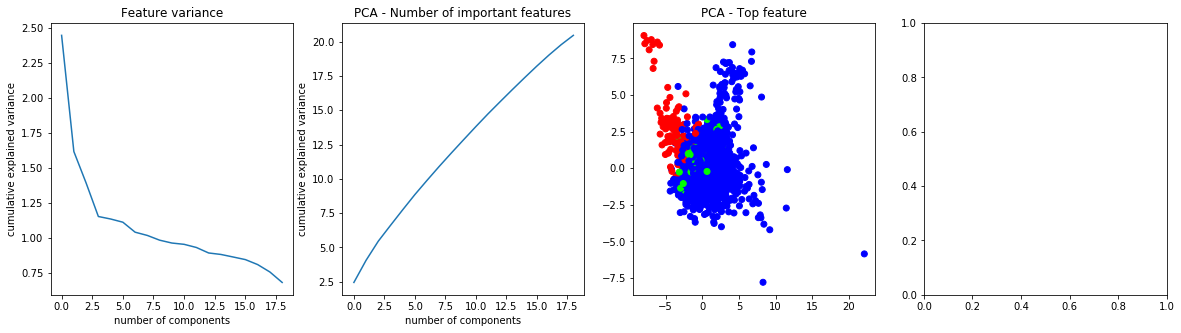

In [106]:
from math import ceil
cntItems = 1
rowItems = 4
fig, ax = plt.subplots(cntItems,rowItems,figsize=(20,5))
if cntItems == 1: axlist = range(rowItems)
else: axlist = list(product(range(cntItems),range(rowItems)))

# Plot feature variance
ax[axlist[0]].set_title("Feature variance")
ax[axlist[0]].set_xlabel('number of components')
ax[axlist[0]].set_ylabel('cumulative explained variance');
feature_variance = np.var(input_train, 0)
ax[axlist[0]].plot(feature_variance)

# Plot importance of features
ax[axlist[1]].set_title("PCA - Number of important features")
ax[axlist[1]].plot(np.cumsum(pca.explained_variance_))
ax[axlist[1]].set_xlabel('number of components')
ax[axlist[1]].set_ylabel('cumulative explained variance');
ax[axlist[1]].set_xlim(-1)

#print("derp",len([*zip(*pca_X)]))
#print(list(*zip(pca_X[,0],pca_X[0,:])))
#*zip(pca_X[:,0],pca_X[0,:]
ax[axlist[2]].set_title("PCA - Top feature")
ax[axlist[2]].scatter(input_train[:,0], input_train[:,1], c=target_train.squeeze())

#ax[axlist[3]].set_title("PCA - Feature importance")
#ax[axlist[3]].matshow(pca.components_,cmap='viridis')
#ax[axlist[3]].set_yticks([0,1,2],['1st Comp','2nd Comp','3rd Comp'])

plt.show()



## Plot histogram over top features

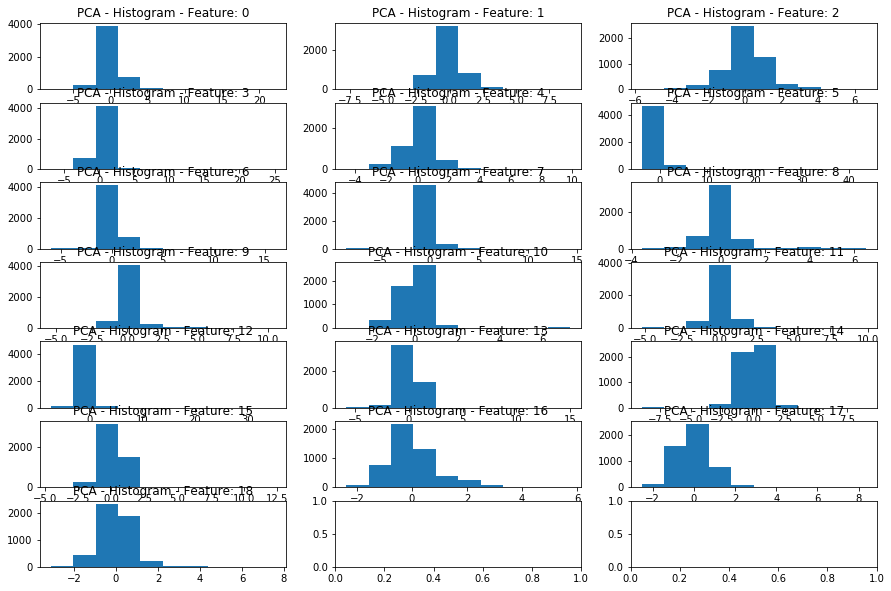

In [107]:
from math import ceil
startpos = 1
cntPlots = len(input_train[0])
rowItems = 3
cntItems = ceil(cntPlots/rowItems)

fig, ax = plt.subplots(cntItems,rowItems,figsize=(15,10))
if cntItems == 0: axlist = range(rowItems)
else: axlist = list(product(range(cntItems),range(rowItems)))


for index in range(0,(cntPlots)):
    ax[axlist[index]].set_title("PCA - Histogram - Feature: " + str(index))
    ax[axlist[index]].hist(input_train[:,index])
    
plt.show()

## Top ten features

In [108]:
# May not work?
pca_trans = pca.transform(np.eye(input_train_copy_normalized.shape[1]))
toptenfeatures = np.argsort(np.linalg.norm(pca_trans,axis=1))[::-1][:10]

print("Top features:",toptenfeatures)


"""
import seaborn as sns
s=sns.heatmap(np.corrcoef(pca_X),cmap='coolwarm') 
s.set_yticklabels(s.get_yticklabels(),rotation=30,fontsize=7)
s.set_xticklabels(s.get_xticklabels(),rotation=30,fontsize=7)
"""
plt.show()

Top features: [12  7 14  3  9 15  5 11 10 16]


## Hyperparameter tuning

In [ ]:
#https://ramhiser.com/post/2018-03-25-feature-selection-with-scikit-learn-pipeline/

from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.linear_model import Lasso,ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV, learning_curve,validation_curve

N_FEATURES_COMPONENT = np.arange(2,10,2)

feature_select = [
        #PCA(iterated_power=N_FEATURES_COMPONENT), 
        #SelectKBest(f_regression),
        #ExtraTreesRegressor(random_state=seed, n_estimators=250),
        #RFE(RandomForestRegressor())
    ]


# GridSearchCV
estimators = [
    #('reduce_dim','passthrough'),
    ('clf', LinearSVC()),
]
param_grid = [
    {
        #'reduce_dim': feature_select,
        'clf':[LinearSVC()],
        'clf__penalty':['l1','l2'],
        'clf__C': [0.1,0.5,1,1.5,2.0],
        'clf__dual':[True,False]
    },{
        #'reduce_dim': feature_select,
        'clf':[KNeighborsClassifier()],
        'clf__n_neighbors':[5,3,6,8],
        'clf__algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],
        'clf__leaf_size':[30,15,20,40]
    },{
    #'reduce_dim': feature_select,
    'clf':[SVC()],
    'clf__C':[1,0.5,1,5.2],
    'clf__kernel':['linear', 'poly', 'rbf', 'sigmoid'],
    'clf__degree':[1,2,3],
    'clf__gamma':['scale', 'auto'],
    'clf__max_iter':[-1,1000,5000,10000],
}]


pipeline = Pipeline(estimators)
grid = GridSearchCV(
    pipeline,
    cv=k, 
    param_grid=param_grid,
    return_train_score=True,
    refit=True,
    n_jobs=-1,
    scoring=scoring
) 
grid.fit(input_train,target_train)

## Get Model info

In [ ]:
param_cols = ['']
score_cols = ['mean_train_score', 'std_test_score','mean_test_score', 'std_test_score']

grid_df = pd.DataFrame(grid.cv_results_, columns=score_cols)
grid_df.sort_values(by=['mean_test_score']).tail()
#print(grid_df)

print(f"Best score: {grid.best_score_}\nBest params {grid.best_params_}")

In [ ]:
# Parameter to
param_range = np.arange(0.01, 50,5)
model = grid.best_params_['clf']
fig, axes = plt.subplots(3, 1, figsize=(10, 15))
plot_learning_curve(model, model.__class__.__name__, input_train, target_train, axes=axes[:], cv=k, scoring=scoring, n_jobs=-1)
plt.show()

In [ ]:
train_scores, test_scores = validation_curve(model, input_train, target_train,scoring=scoring, n_jobs=-1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with SVM")
plt.xlabel(r"$\gamma$")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()